In [22]:
train_name = "vqc_adam_xx" 

Separar datasets de treinamento e teste, separar as features que serão utilizadas.
Preencher nan com a média de valores da coluna.  // Testar também normalização [0;pi]

In [23]:
import numpy as np
import pandas as pd 

In [24]:
train = pd.read_csv("../dataset/train_normalized.csv")
test = pd.read_csv("../dataset/test_normalized.csv")

In [25]:
y_train = train['label']
y_test = test['label']

## FEATURE SELECTION

In [26]:
selected_features = ["proto", "orig_bytes", "conn_state", "resp_pkts", "resp_ip_bytes"]
num_features = len(selected_features)

In [27]:
train = train[selected_features]
test = test[selected_features]

In [28]:
train.head(5)

,proto,orig_bytes,conn_state,resp_pkts,resp_ip_bytes
0,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
1,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
2,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
3,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
4,0.5,2.382635e-07,0.833333,0.000017,6.178160e-07


Definir o Label para treinamento (característica que se quer prever)

## FEATURE MAP

XXFeatureMap

Nº de features = tamanho do vetor de features

FeatureMap = XXFeatureMap com dimensões nº de features e 1 repetição

Decompose e draw FeatureMap, output "mpl", fold = 40

In [29]:
from qiskit.circuit.library import PauliFeatureMap

feature_map = PauliFeatureMap(num_features, reps = 1, paulis=["xx"])

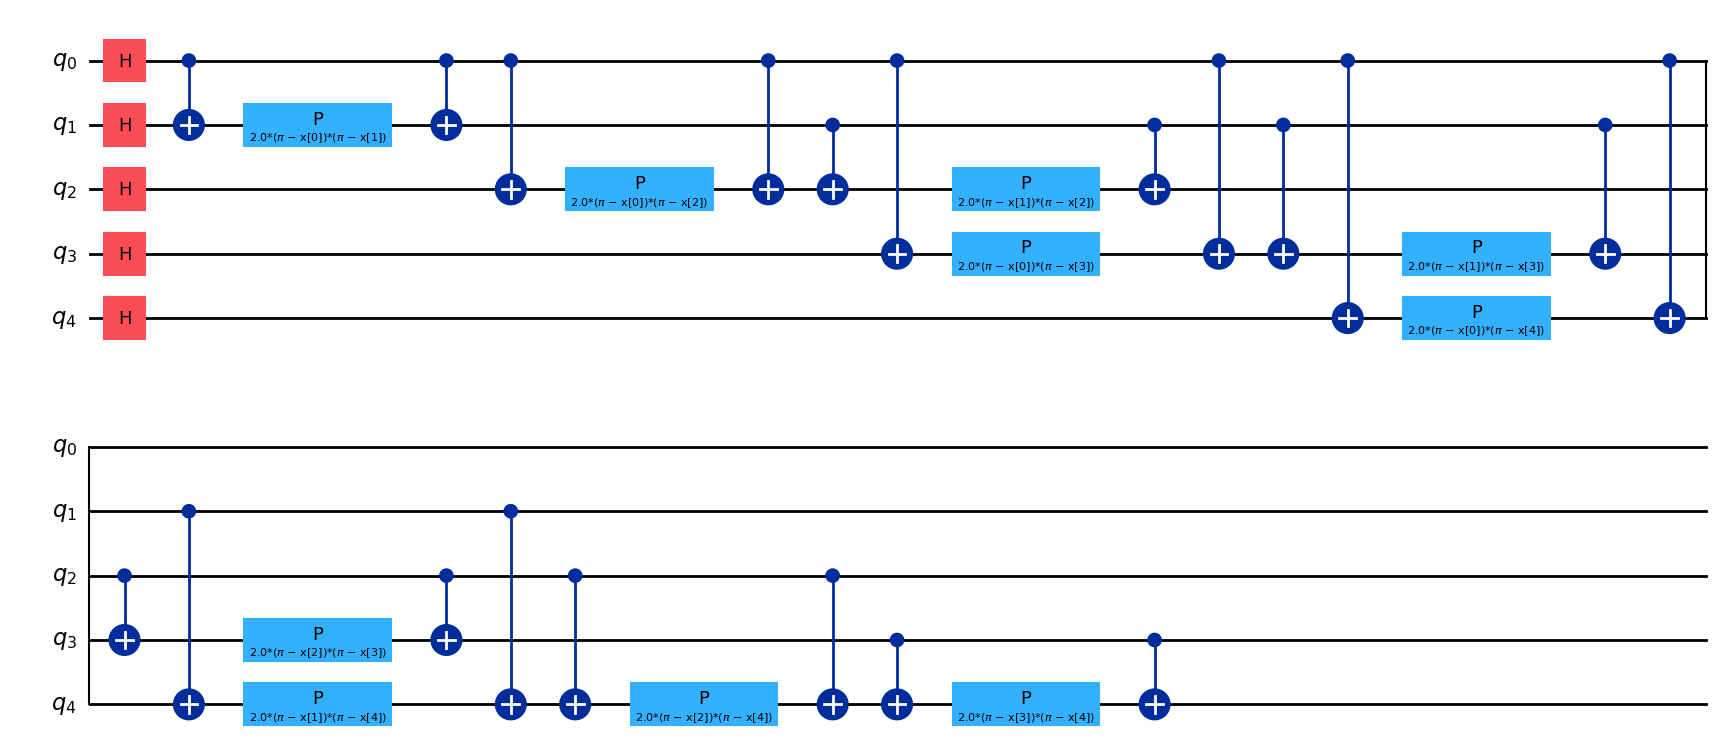

In [30]:
feature_map.decompose().draw(output = "mpl", fold = 25)

## Ansatz

#### TwoLocal
https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal -> ENTENDER MELHOR

TwoLocal.__Subclasses__() -> Ansatz = RealAmplitudes com nº de qubits = nº de features e 2 repetições

Decompose e draw Ansatz, output "mpl", fold = 20

In [31]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_features, reps = 2)

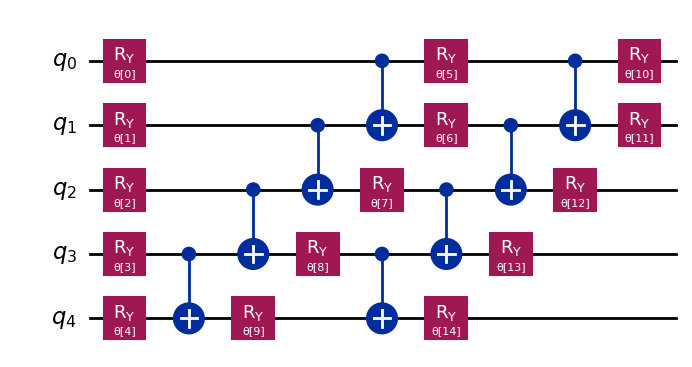

In [32]:
ansatz.decompose().draw(output = "mpl", fold = 40)

## Callback Function
Importar pyplot para plotar gráfico da função custo pelas iterações - callback_graph

In [33]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
objective_func_vals_adam = []
plt.rcParams["figure.figsize"]= (12,6)

def callback_graph(weights, obj_func_eval): #
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Função de Custo")
    plt.xlabel("Iterações")
    plt.ylabel("Função de Custo")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

def callback_graph_adam(n_iter, weights, obj_func_eval):
    """
    ADAM will call this with
      n_iter        : int, the current iteration (0, 1, 2, …)
      weights       : np.ndarray, the current parameter vector
      obj_func_eval : float,   the cost at that parameter vector
    """
    # erase previous plot
    clear_output(wait=True)

    # store and plot
    objective_func_vals_adam.append(obj_func_eval)
    plt.plot(objective_func_vals_adam, linewidth=2)
    plt.title("Função de Custo")
    plt.xlabel("Iterações")
    plt.ylabel("Função de Custo")
    plt.grid(True)
    plt.show()

## OTIMIZADOR

#### ADAM

Rodar com configurações padrão.

In [34]:
from qiskit_machine_learning.optimizers import ADAM
optimizer = ADAM(maxiter=100, callback=callback_graph_adam)

## SAMPLER
Erro no VQC, checar motivo

Importar Sampler, shots=512 -> https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler

In [35]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()


## VQC
Importar classificador VQC do Qiskit -> https://github.com/qiskit-community/qiskit-machine-learning // https://qiskit-community.github.io/qiskit-machine-learning/getting_started.html#installation

VQC { sampler = sampler; feature_map = feature_map, ansatz = ansatz; optimizer = optimizer; callback = callback_graph }

Importar time para visualizar o tempo de execução

VQC.fit(train_features, train_labels.values)

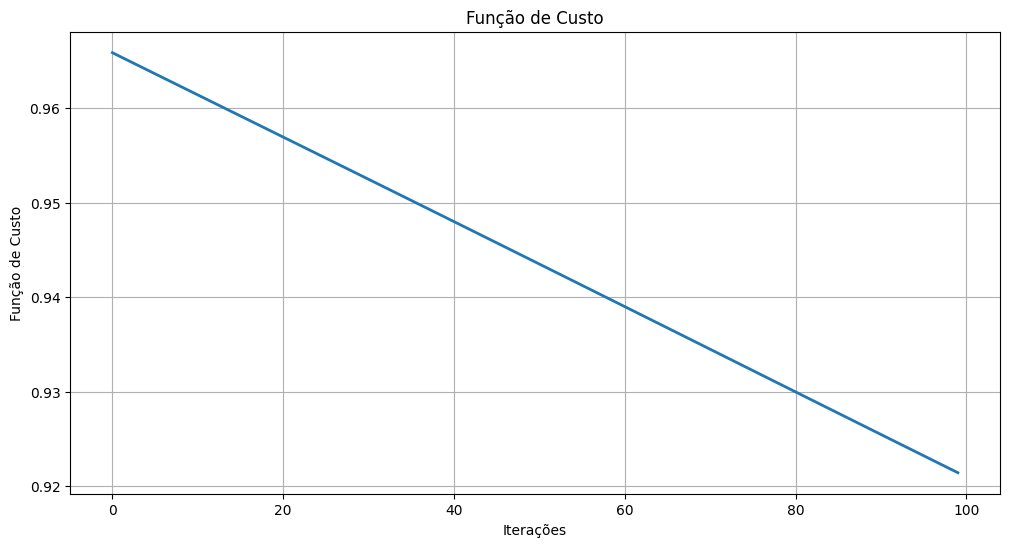

Training time: 156735 seconds


In [36]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_aer import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

sim = AerSimulator(method='statevector', device='GPU')

vqc = VQC(
    #sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    #callback=callback_graph,
    pass_manager=generate_preset_pass_manager(backend=sim)
)

start = time.time()
vqc.fit(train, y_train.values)
elapsed = time.time() - start

vqc.save(f'trained_models/{train_name}.model')


print(f"Training time: {round(elapsed)} seconds")

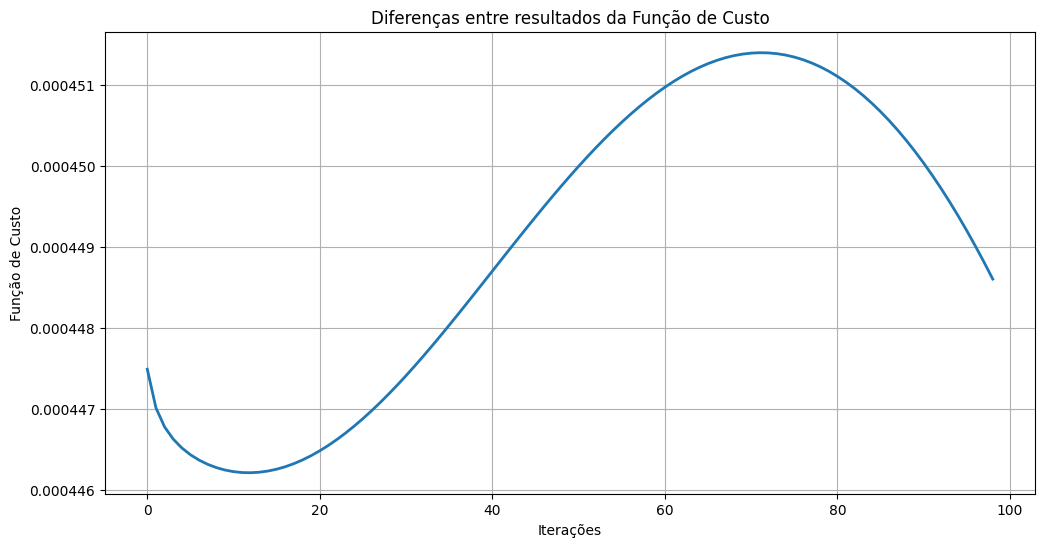

In [37]:
differences = [objective_func_vals_adam[i] - objective_func_vals_adam[i+1] for i in range(len(objective_func_vals_adam)-1)]

plt.plot(differences, linewidth=2)
plt.title("Diferenças entre resultados da Função de Custo")
plt.xlabel("Iterações")
plt.ylabel("Função de Custo")
plt.grid(True)
plt.show()

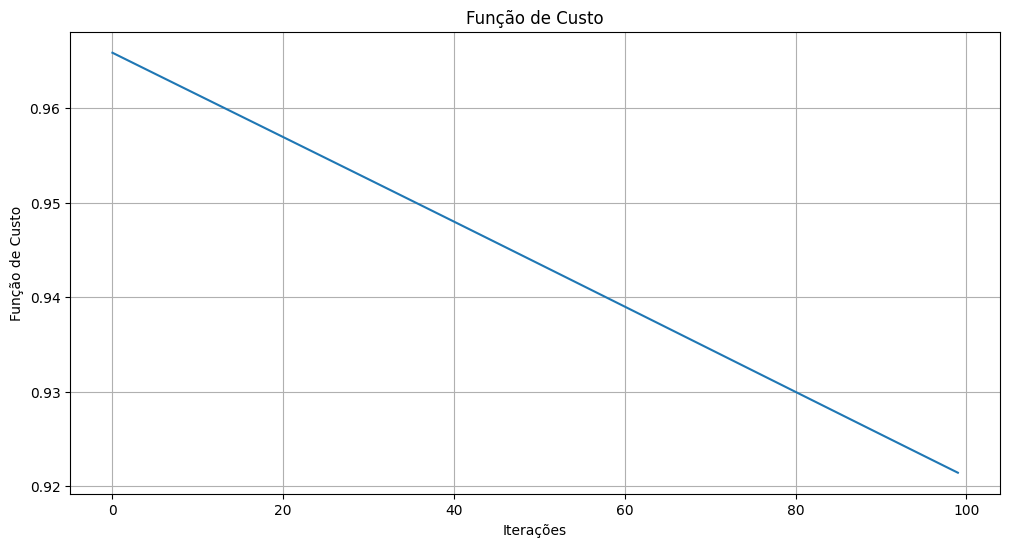

In [38]:
plt.plot(range(len(objective_func_vals_adam)), objective_func_vals_adam)
plt.title("Função de Custo")
plt.xlabel("Iterações")
plt.ylabel("Função de Custo")
plt.grid(True)
plt.show()

In [39]:
print(objective_func_vals)

[]


In [40]:
train_acc = vqc.score(train, y_train)
print(f'Acuracia: {round(train_acc,2)*100}%')

Acuracia: 67.0%


Rodar com o teste -> VQC.predict(test);

Realizar avaliação dos resultados (acurácia, precisão, recall...)

In [41]:
y_predicted = vqc.predict(test)

y_predicted

array([1., 1., 1., ..., 1., 1., 1.])

In [42]:
import sklearn.metrics as metrics
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.45      0.08      0.13      6575
         1.0       0.68      0.95      0.80     13655

    accuracy                           0.67     20230
   macro avg       0.57      0.52      0.47     20230
weighted avg       0.61      0.67      0.58     20230



In [43]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
print(confusion_matrix)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predicted).ravel()

print(tn, fp, fn, tp)

[[  520  6055]
 [  635 13020]]
520 6055 635 13020
